<a href="https://colab.research.google.com/github/Tri-mis/San-Lua-Project/blob/main/Rice_count_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
from scipy.spatial import KDTree
import json
import os
import glob
import cv2
import matplotlib.pyplot as plt
import random
import torch
import cv2
from skimage.feature import peak_local_max

In [2]:
# ================================= Rice Class ================================= #
class Rice:
    def __init__(self, rice_json = None):
        if rice_json is not None:
            self.seg = rice_json["segmentation"][0]
            self.centroid = self.compute_centroid()
            self.rice_type = "empty" if rice_json["category_id"] == 1 else "full"
        else:
            self.seg = None
            self.centroid = None
            self.rice_type = None

    def compute_centroid(self):
        pts = np.array(self.seg).reshape(-1, 2)
        return int(pts[:, 0].mean()), int(pts[:, 1].mean())


# ================================= Image Class ================================= #
class Image:
    def __init__(self, img_json = None, folder = None):
        if img_json is not None:
            self.id = img_json["id"]
            self.file_name = img_json["file_name"]
            self.path = os.path.join(folder, self.file_name)
        else:
            self.id = None
            self.file_name = None
            self.path = None

        self.rice_list = []
        self.img = None
        self.density_map = None

    def load_image(self):
        if self.img is None:
            self.img = cv2.imread(self.path)
        return self.img

    def compute_density_map(self, density_map_shape=(256,256), k=1, min_sigma=0.5, max_sigma=4.0):
        img = self.load_image()
        H, W = img.shape[:2]

        # Full-resolution density map
        full_density = np.zeros((H, W), dtype=np.float32)
        pts = np.array([rice.centroid for rice in self.rice_list])

        if len(pts) == 0:
            # Empty density map
            H_out, W_out = density_map_shape
            self.density_map = np.zeros((H_out, W_out), dtype=np.float32)
            return self.density_map

        # KDTree for neighbor distance
        tree = KDTree(pts)
        distances, _ = tree.query(pts, k=k+1)  # k+1 because the point itself counts
        sigmas = np.clip(np.mean(distances[:, 1:], axis=1) * 0.3, min_sigma, max_sigma)

        # Build adaptive Gaussian density map
        for (x, y), sigma in zip(pts, sigmas):
            size = int(6 * sigma)
            if size % 2 == 0:
                size += 1

            ax = np.arange(-size//2 + 1., size//2 + 1.)
            xx, yy = np.meshgrid(ax, ax)
            g = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
            g /= g.sum()  # normalize Gaussian so sum = 1

            k_half = size // 2
            x1, y1 = max(0, x-k_half), max(0, y-k_half)
            x2, y2 = min(W, x+k_half+1), min(H, y+k_half+1)

            gx1, gy1 = max(0, k_half-x), max(0, k_half-y)
            gx2, gy2 = gx1 + (x2-x1), gy1 + (y2-y1)

            full_density[y1:y2, x1:x2] += g[gy1:gy2, gx1:gx2]

        # Resize density map to requested output shape
        H_out, W_out = density_map_shape
        self.density_map = cv2.resize(full_density, (W_out, H_out), interpolation=cv2.INTER_AREA)

        # Preserve total sum (total count) after resizing
        scale = (H * W) / (H_out * W_out)
        self.density_map *= scale

        return self.density_map

# ================================= Helper functions ================================= #
# ============ load_dataset ============ #
def load_dataset(folder, density_map_shape):
    json_file = glob.glob(os.path.join(folder, "*.json"))[0]

    with open(json_file) as f:
        data = json.load(f)

    images = {}

    # Create Image objects
    for img_json in data["images"]:
        images[img_json["id"]] = Image(img_json, folder)

    # Add Rice objects to corresponding Image objects
    for ann in data["annotations"]:
        img_id = ann["image_id"]
        rice_obj = Rice(ann)
        images[img_id].rice_list.append(rice_obj)

    for imm_obj in images.values():
        imm_obj.compute_density_map(density_map_shape)

    return list(images.values())

# ============ draw_img_ann ============ #
def draw_img_ann(img_obj):
    # Load the image
    img = cv2.imread(img_obj.path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis("off")

    # Draw each rice polygon
    for rice in img_obj.rice_list:
        seg = np.array(rice.seg).reshape(-1, 2)

        # Choose color based on rice type
        if rice.rice_type == "full":
            # Shades of green (R,G,B) in [0,1] for matplotlib
            # Randomize brightness slightly
            r = np.random.uniform(0, 0.3)
            g = np.random.uniform(0.5, 1.0)
            b = np.random.uniform(0, 0.3)
            color = (r, g, b)
        else:  # empty
            # Shades of orange: R high, G medium, B low
            r = np.random.uniform(0.8, 1.0)
            g = np.random.uniform(0.4, 0.7)
            b = np.random.uniform(0, 0.2)
            color = (r, g, b)

        plt.fill(seg[:, 0], seg[:, 1], color=color, alpha=0.5)

    plt.show()

# ============ draw_density_map ============ #
def draw_density_map(img_obj):
    if img_obj.density_map is None:
        print("Density map not computed yet.")
        return

    plt.figure(figsize=(6,6))
    plt.title("Density Map")
    plt.imshow(img_obj.density_map, cmap='jet')
    plt.axis("off")
    plt.show()

In [3]:
train_dataset = load_dataset("/content/drive/MyDrive/Rice counting project/Dataset/rice-grain-counting.v4i.coco-segmentation/train", (128,128))
valid_dataset = load_dataset("/content/drive/MyDrive/Rice counting project/Dataset/rice-grain-counting.v4i.coco-segmentation/valid", (128,128))
test_dataset = load_dataset("/content/drive/MyDrive/Rice counting project/Dataset/rice-grain-counting.v4i.coco-segmentation/test", (128,128))


Shape of image: (1024, 1024, 3)
Shape of density map: (128, 128)


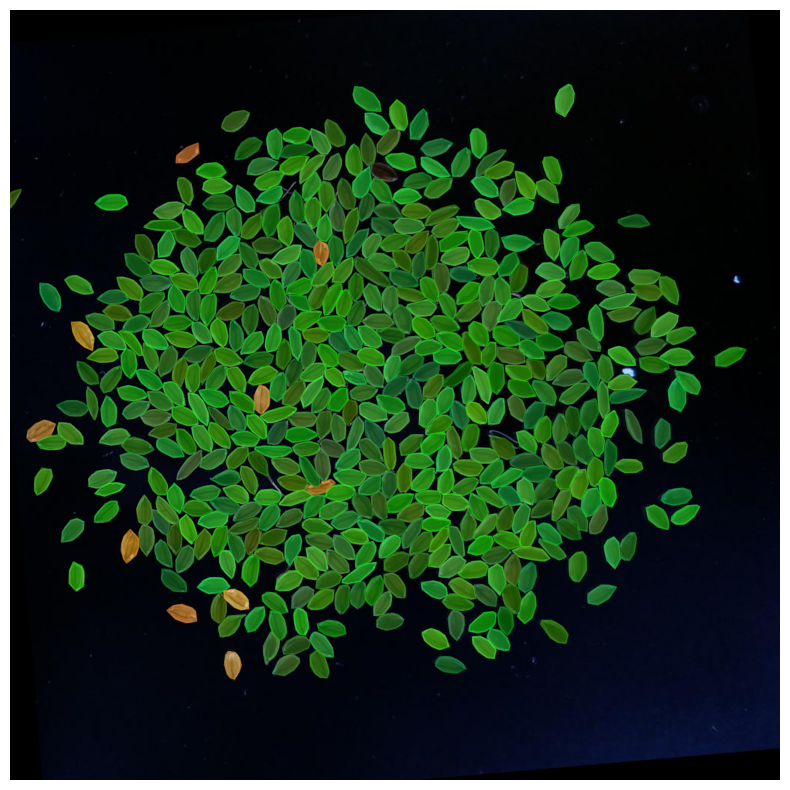

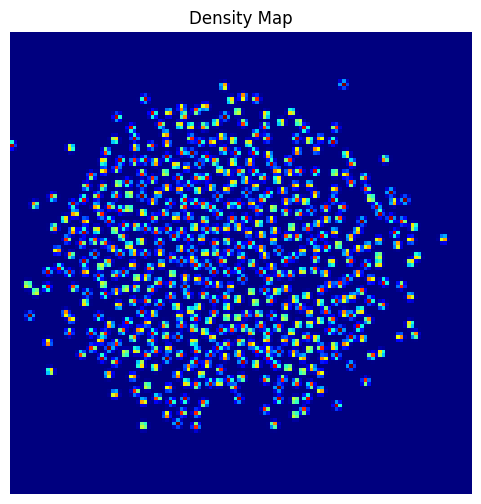

In [19]:
print(f"Shape of image: {train_dataset[4].img.shape}")
print(f"Shape of density map: {train_dataset[4].density_map.shape}")
draw_img_ann(train_dataset[4])
draw_density_map(train_dataset[4])

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms
from tqdm import tqdm

# ======================== CSRNet MODEL ======================== #
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:17])  # conv1_1 -> conv4_3
        self.backend = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )
        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

# ======================== Collate function for DataLoader ======================== #
def collate_fn(batch):
    imgs = []
    densities = []
    for img_obj in batch:
        # Convert image to tensor CxHxW
        img = transforms.ToTensor()(cv2.cvtColor(img_obj.img, cv2.COLOR_BGR2RGB))
        imgs.append(img)

        # Convert density map to tensor 1xHxW
        density = torch.tensor(img_obj.density_map, dtype=torch.float32).unsqueeze(0)
        densities.append(density)

    return torch.stack(imgs), torch.stack(densities)

# ======================== Training function ======================== #
def train_csrnet(train_dataset, val_dataset, batch_size=4, lr=1e-5, epochs=500, patience=5, save_path="best_csrnet.pth"):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model = CSRNet().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    trigger_times = 0

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        train_loss = 0
        for imgs, dens in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            imgs, dens = imgs.to(device), dens.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, dens)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)

        # ---- VALIDATION ----
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, dens in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                imgs, dens = imgs.to(device), dens.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, dens)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        print(f"\nEpoch {epoch+1}, Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # ---- EARLY STOPPING ----
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            trigger_times = 0
            torch.save(model.state_dict(), save_path)
            print("Validation loss decreased. Model saved.")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    print("Training complete!")
    return model


In [6]:
model = train_csrnet(train_dataset, valid_dataset, patience = 3, batch_size=4, lr=1e-5, epochs=100)

Using device: cuda
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 166MB/s]
Epoch 1/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]



Epoch 1, Train Loss = 0.0075, Val Loss = 0.0081
Validation loss decreased. Model saved.


Epoch 2/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]



Epoch 2, Train Loss = 0.0054, Val Loss = 0.0061
Validation loss decreased. Model saved.


Epoch 3/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]



Epoch 3, Train Loss = 0.0044, Val Loss = 0.0061


Epoch 4/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]



Epoch 4, Train Loss = 0.0046, Val Loss = 0.0062


Epoch 5/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]



Epoch 5, Train Loss = 0.0044, Val Loss = 0.0057
Validation loss decreased. Model saved.


Epoch 6/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]



Epoch 6, Train Loss = 0.0042, Val Loss = 0.0057


Epoch 7/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]



Epoch 7, Train Loss = 0.0042, Val Loss = 0.0058


Epoch 8/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]



Epoch 8, Train Loss = 0.0042, Val Loss = 0.0056
Validation loss decreased. Model saved.


Epoch 9/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]



Epoch 9, Train Loss = 0.0041, Val Loss = 0.0055
Validation loss decreased. Model saved.


Epoch 10/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]



Epoch 10, Train Loss = 0.0040, Val Loss = 0.0054
Validation loss decreased. Model saved.


Epoch 11/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]



Epoch 11, Train Loss = 0.0040, Val Loss = 0.0053
Validation loss decreased. Model saved.


Epoch 12/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]



Epoch 12, Train Loss = 0.0039, Val Loss = 0.0052
Validation loss decreased. Model saved.


Epoch 13/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]



Epoch 13, Train Loss = 0.0038, Val Loss = 0.0050
Validation loss decreased. Model saved.


Epoch 14/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]



Epoch 14, Train Loss = 0.0037, Val Loss = 0.0048
Validation loss decreased. Model saved.


Epoch 15/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]



Epoch 15, Train Loss = 0.0035, Val Loss = 0.0046
Validation loss decreased. Model saved.


Epoch 16/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]



Epoch 16, Train Loss = 0.0033, Val Loss = 0.0043
Validation loss decreased. Model saved.


Epoch 17/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]



Epoch 17, Train Loss = 0.0031, Val Loss = 0.0039
Validation loss decreased. Model saved.


Epoch 18/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]



Epoch 18, Train Loss = 0.0028, Val Loss = 0.0035
Validation loss decreased. Model saved.


Epoch 19/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]



Epoch 19, Train Loss = 0.0025, Val Loss = 0.0031
Validation loss decreased. Model saved.


Epoch 20/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]



Epoch 20, Train Loss = 0.0022, Val Loss = 0.0027
Validation loss decreased. Model saved.


Epoch 21/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]



Epoch 21, Train Loss = 0.0020, Val Loss = 0.0024
Validation loss decreased. Model saved.


Epoch 22/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]



Epoch 22, Train Loss = 0.0018, Val Loss = 0.0023
Validation loss decreased. Model saved.


Epoch 23/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]



Epoch 23, Train Loss = 0.0017, Val Loss = 0.0022
Validation loss decreased. Model saved.


Epoch 24/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



Epoch 24, Train Loss = 0.0016, Val Loss = 0.0021
Validation loss decreased. Model saved.


Epoch 25/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



Epoch 25, Train Loss = 0.0016, Val Loss = 0.0020
Validation loss decreased. Model saved.


Epoch 26/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



Epoch 26, Train Loss = 0.0015, Val Loss = 0.0020
Validation loss decreased. Model saved.


Epoch 27/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]



Epoch 27, Train Loss = 0.0015, Val Loss = 0.0019
Validation loss decreased. Model saved.


Epoch 28/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]



Epoch 28, Train Loss = 0.0014, Val Loss = 0.0019
Validation loss decreased. Model saved.


Epoch 29/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



Epoch 29, Train Loss = 0.0014, Val Loss = 0.0018
Validation loss decreased. Model saved.


Epoch 30/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]



Epoch 30, Train Loss = 0.0014, Val Loss = 0.0018
Validation loss decreased. Model saved.


Epoch 31/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]



Epoch 31, Train Loss = 0.0014, Val Loss = 0.0018


Epoch 32/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]



Epoch 32, Train Loss = 0.0013, Val Loss = 0.0018
Validation loss decreased. Model saved.


Epoch 33/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]



Epoch 33, Train Loss = 0.0013, Val Loss = 0.0017
Validation loss decreased. Model saved.


Epoch 34/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]



Epoch 34, Train Loss = 0.0013, Val Loss = 0.0017
Validation loss decreased. Model saved.


Epoch 35/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]



Epoch 35, Train Loss = 0.0013, Val Loss = 0.0017


Epoch 36/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]



Epoch 36, Train Loss = 0.0012, Val Loss = 0.0017
Validation loss decreased. Model saved.


Epoch 37/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]



Epoch 37, Train Loss = 0.0012, Val Loss = 0.0016
Validation loss decreased. Model saved.


Epoch 38/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



Epoch 38, Train Loss = 0.0012, Val Loss = 0.0016
Validation loss decreased. Model saved.


Epoch 39/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]



Epoch 39, Train Loss = 0.0012, Val Loss = 0.0016
Validation loss decreased. Model saved.


Epoch 40/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



Epoch 40, Train Loss = 0.0011, Val Loss = 0.0016
Validation loss decreased. Model saved.


Epoch 41/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



Epoch 41, Train Loss = 0.0011, Val Loss = 0.0015
Validation loss decreased. Model saved.


Epoch 42/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]



Epoch 42, Train Loss = 0.0011, Val Loss = 0.0015
Validation loss decreased. Model saved.


Epoch 43/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]



Epoch 43, Train Loss = 0.0011, Val Loss = 0.0015
Validation loss decreased. Model saved.


Epoch 44/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]



Epoch 44, Train Loss = 0.0011, Val Loss = 0.0015
Validation loss decreased. Model saved.


Epoch 45/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]



Epoch 45, Train Loss = 0.0011, Val Loss = 0.0015
Validation loss decreased. Model saved.


Epoch 46/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]



Epoch 46, Train Loss = 0.0011, Val Loss = 0.0015
Validation loss decreased. Model saved.


Epoch 47/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



Epoch 47, Train Loss = 0.0010, Val Loss = 0.0014
Validation loss decreased. Model saved.


Epoch 48/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



Epoch 48, Train Loss = 0.0010, Val Loss = 0.0014
Validation loss decreased. Model saved.


Epoch 49/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



Epoch 49, Train Loss = 0.0010, Val Loss = 0.0014
Validation loss decreased. Model saved.


Epoch 50/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]



Epoch 50, Train Loss = 0.0010, Val Loss = 0.0014
Validation loss decreased. Model saved.


Epoch 51/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]



Epoch 51, Train Loss = 0.0010, Val Loss = 0.0014
Validation loss decreased. Model saved.


Epoch 52/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]



Epoch 52, Train Loss = 0.0010, Val Loss = 0.0014
Validation loss decreased. Model saved.


Epoch 53/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]



Epoch 53, Train Loss = 0.0010, Val Loss = 0.0014
Validation loss decreased. Model saved.


Epoch 54/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



Epoch 54, Train Loss = 0.0010, Val Loss = 0.0014
Validation loss decreased. Model saved.


Epoch 55/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]



Epoch 55, Train Loss = 0.0009, Val Loss = 0.0013
Validation loss decreased. Model saved.


Epoch 56/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]



Epoch 56, Train Loss = 0.0009, Val Loss = 0.0013
Validation loss decreased. Model saved.


Epoch 57/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]



Epoch 57, Train Loss = 0.0009, Val Loss = 0.0013
Validation loss decreased. Model saved.


Epoch 58/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]



Epoch 58, Train Loss = 0.0009, Val Loss = 0.0013


Epoch 59/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]



Epoch 59, Train Loss = 0.0009, Val Loss = 0.0013


Epoch 60/100 [Val]: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


Epoch 60, Train Loss = 0.0009, Val Loss = 0.0013
Early stopping triggered at epoch 60
Training complete!


In [7]:
from google.colab import drive
drive.mount('/content/drive')  # mount your Google Drive

save_path = "/content/drive/MyDrive/Rice counting project/Colab Notebooks/best_csrnet.pth"
torch.save(model.state_dict(), save_path)
print("Model saved to Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive!


In [6]:
def load_csrnet(weight_path, device="cuda"):
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    model = CSRNet().to(device)

    state_dict = torch.load(weight_path, map_location=device)
    model.load_state_dict(state_dict)

    model.eval()
    print(f"Loaded CSRNet from: {weight_path}")
    return model

In [39]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

def predict_density_and_peaks(img_obj, model, device=None, threshold_rel=0.25):
    model.eval()

    # --- Auto-detect device ---
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)

    # --- Prepare input ---
    img = img_obj.load_image()
    img_tensor = torch.tensor(
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
        dtype=torch.float32
    ).permute(2, 0, 1).unsqueeze(0) / 255.0
    img_tensor = img_tensor.to(device)

    # --- Predict ---
    with torch.no_grad():
        pred_density = model(img_tensor)  # 1×1×h×w
    pred_density = pred_density.squeeze().cpu().numpy()  # h×w

    # --- Upsample to full resolution ---
    H, W = img.shape[:2]
    pred_density_up = cv2.resize(pred_density, (W, H), interpolation=cv2.INTER_CUBIC)

    # --- Peak finding ---
    coordinates = peak_local_max(
        pred_density_up,
        min_distance=1,
        threshold_rel=threshold_rel
    )

    return pred_density_up, coordinates



def plot_density_and_peaks(img_obj, pred_density_up, coordinates):
    # --- Plot density map ---
    plt.figure(figsize=(6, 6))
    plt.title("Upsampled Predicted Density Map")
    plt.imshow(pred_density_up, cmap='jet')
    plt.axis("off")
    plt.show()

    # --- Plot original image with peaks ---
    plt.figure(figsize=(10, 10))
    img_rgb = cv2.cvtColor(img_obj.img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.scatter(coordinates[:, 1], coordinates[:, 0], c='red', s=1)
    plt.axis("off")
    plt.title(f"Detected Grains: {len(coordinates)}")
    plt.show()


def segment_grains(img_obj, coordinates, window=40, fg_radius=10, full_empty_threshold=60):

    img = img_obj.load_image()

    result = Image()
    result.id = img_obj.id
    result.file_name = img_obj.file_name
    result.path = img_obj.path
    result.img = img
    result.density_map = img_obj.density_map
    result.rice_list = []

    H, W = img.shape[:2]

    for (y, x) in coordinates:

        # --- 1. Extract patch ---
        y1 = max(0, y - window)
        y2 = min(H, y + window)
        x1 = max(0, x - window)
        x2 = min(W, x + window)

        patch = img[y1:y2, x1:x2]
        ph, pw = patch.shape[:2]

        # --- 2. Init GC mask ---
        mask = np.full((ph, pw), 2, np.uint8)   # probable bg
        mask[0, :] = mask[-1, :] = 0
        mask[:, 0] = mask[:, -1] = 0

        local_y = y - y1
        local_x = x - x1
        cv2.circle(mask, (local_x, local_y), fg_radius, 1, -1)

        # --- 3. GrabCut ---
        bgd = np.zeros((1, 65), np.float64)
        fgd = np.zeros((1, 65), np.float64)
        cv2.grabCut(patch, mask, None, bgd, fgd, 5, cv2.GC_INIT_WITH_MASK)

        # --- 4. Final FG mask ---
        fg = ((mask == 1) | (mask == 3)).astype("uint8") * 255

        # --- 5. Contour ---
        cnts, _ = cv2.findContours(fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(cnts) == 0:
            continue

        c = max(cnts, key=cv2.contourArea)

        # polygon approx
        peri = cv2.arcLength(c, True)
        eps = 0.01 * peri
        approx = cv2.approxPolyDP(c, eps, True)

        # Convert to flat [x1, y1, x2, y2 ...]
        poly = []
        for px, py in approx.reshape(-1, 2):
            poly.append(x1 + px)
            poly.append(y1 + py)

        # --- 6. Compute brightness ---
        ys, xs = np.where(fg == 255)
        if len(ys) == 0:
            continue

        grain_pixels = patch[ys, xs]
        avg_bgr = grain_pixels.mean(axis=0)
        brightness = avg_bgr.mean()

        # --- 7. Create Rice object ---
        rice = Rice()
        rice.seg = poly                       # flat list OK for your class
        rice.centroid = (x, y)                # correct order
        rice.rice_type = "full" if brightness < full_empty_threshold else "empty"

        result.rice_list.append(rice)

    return result


In [ ]:
model = load_csrnet("/content/drive/MyDrive/Rice counting project/Colab Notebooks/best_csrnet.pth")

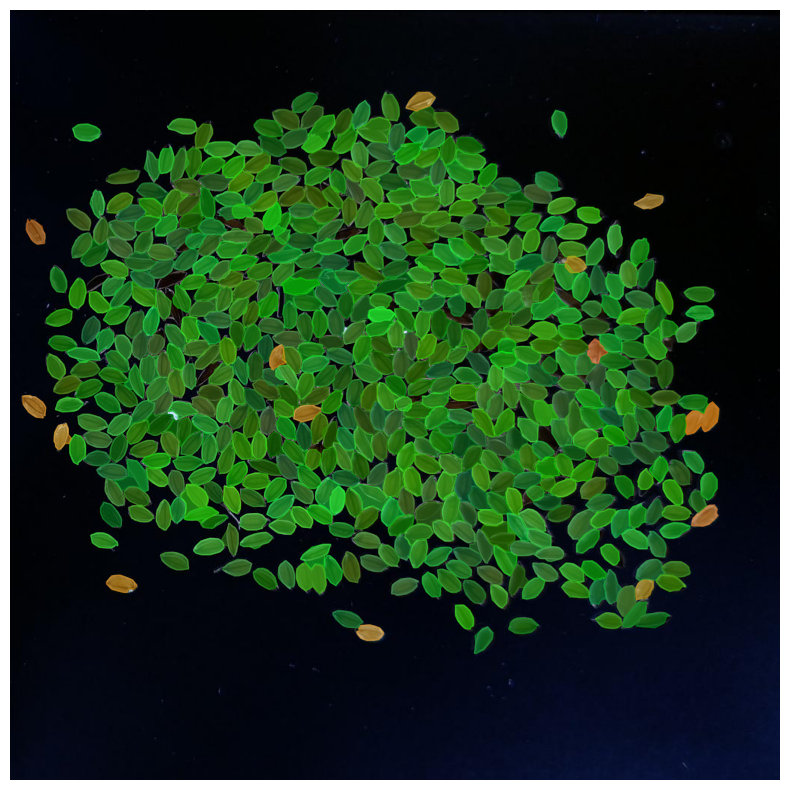

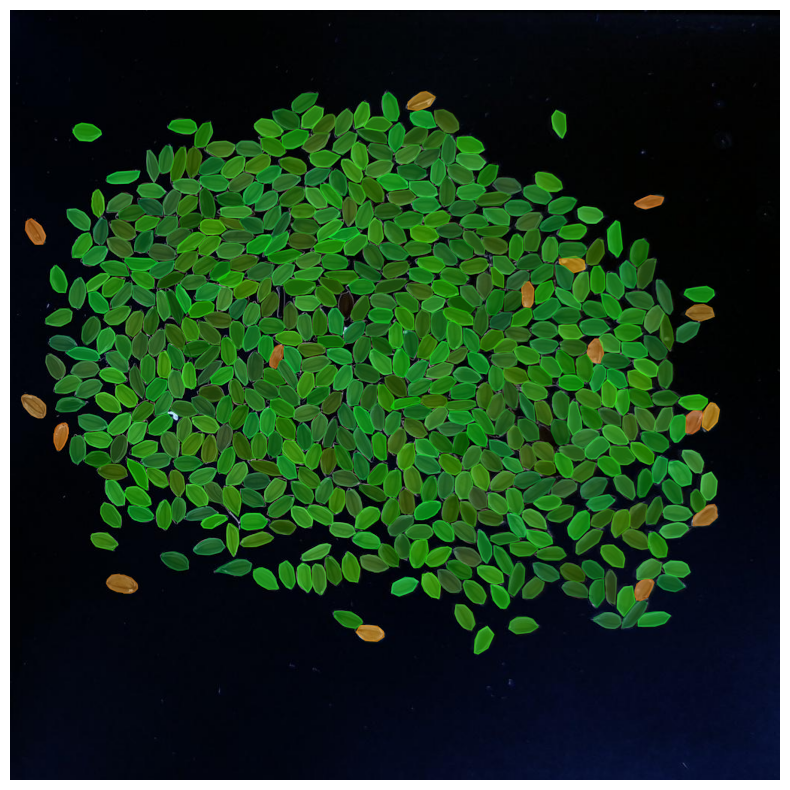

Detected grains: 605
Real grains: 612
detected count / real count = 98.86%


In [57]:
test_img_obj = test_dataset[3]

pred_density_up, coordinates = predict_density_and_peaks(test_img_obj, model)
result_img_obj = segment_grains(test_img_obj, coordinates)
draw_img_ann(result_img_obj)
draw_img_ann(test_img_obj)

real_count = len(test_img_obj.rice_list)
detected_count = len(result_img_obj.rice_list)

print(f"Detected grains: {detected_count}")
print(f"Real grains: {real_count}")
print(f"detected count / real count = {detected_count / real_count * 100.0:.2f}%")

In [47]:
from shapely.geometry import Point, Polygon
import numpy as np

def seg_to_poly(seg):
    poly = Polygon(np.array(seg, dtype=float).reshape(-1, 2))
    if not poly.is_valid:
        poly = poly.buffer(0)  # fix self-intersections
    return poly

def polygon_iou(poly1, poly2):
    p1 = seg_to_poly(poly1)
    p2 = seg_to_poly(poly2)

    inter = p1.intersection(p2).area
    union = p1.union(p2).area
    if union == 0:
        return 0.0
    return inter / union

def compute_rice_metrics(gt_img_obj, pred_img_obj):
    gt_list = gt_img_obj.rice_list
    pred_list = pred_img_obj.rice_list

    # Prepare predicted centroids for matching
    pred_centroids = [Point(r.centroid[0], r.centroid[1]) for r in pred_list]

    matched_pred_indices = set()
    true_positive_info = []   # store (gt_rice, pred_rice, IoU)
    false_positives = 0
    false_negatives = 0

    # For IoU and MAPE (centroid-based)
    iou_full = []
    iou_empty = []
    mape_full = []
    mape_empty = []

    # Count GT and predictions by type
    gt_full_count = sum(r.rice_type=="full" for r in gt_list)
    gt_empty_count = sum(r.rice_type=="empty" for r in gt_list)
    pred_full_count = sum(r.rice_type=="full" for r in pred_list)
    pred_empty_count = sum(r.rice_type=="empty" for r in pred_list)

    # ---- 1. MATCH GROUND-TRUTH TO PREDICTIONS ----
    for gt_idx, gt_rice in enumerate(gt_list):
        gt_poly = seg_to_poly(gt_rice.seg)

        # Find predicted centroids inside this GT polygon
        inside_pred = []
        for p_idx, pred_pt in enumerate(pred_centroids):
            if pred_pt.within(gt_poly):
                inside_pred.append(p_idx)

        if len(inside_pred) == 0:
            # No prediction -> FN
            false_negatives += 1
            continue

        elif len(inside_pred) == 1:
            # Exactly one -> TP
            best_idx = inside_pred[0]

        else:
            # Multiple predictions inside: choose the one with largest IoU as TP
            best_iou = -1
            best_idx = None
            for p_idx in inside_pred:
                pred_poly = seg_to_poly(pred_list[p_idx].seg)
                iou = gt_poly.intersection(pred_poly).area / gt_poly.union(pred_poly).area
                if iou > best_iou:
                    best_iou = iou
                    best_idx = p_idx

            # Others inside → FP
            for p_idx in inside_pred:
                if p_idx != best_idx:
                    false_positives += 1
                    matched_pred_indices.add(p_idx)

        # Mark TP
        matched_pred_indices.add(best_idx)

        pred_r = pred_list[best_idx]
        pred_poly = seg_to_poly(pred_r.seg)
        iou = polygon_iou(gt_rice.seg, pred_r.seg)

        true_positive_info.append((gt_rice, pred_r, iou))

        # Rice type (full vs empty)
        is_full = gt_rice.rice_type == "full"

        # IoU tracking
        if is_full:
            iou_full.append(iou)
        else:
            iou_empty.append(iou)

        # MAPE: centroid distance / GT diagonal
        gt_c = np.array(gt_rice.centroid)
        pred_c = np.array(pred_r.centroid)
        dist = np.linalg.norm(gt_c - pred_c)

        pts = np.array(gt_rice.seg)
        diag = np.linalg.norm(pts.max(axis=0) - pts.min(axis=0))
        if diag == 0:
            diag = 1e-6

        ape = abs(dist / diag) * 100.0

        if is_full:
            mape_full.append(ape)
        else:
            mape_empty.append(ape)

    # ---- 2. UNMATCHED PREDICTIONS ARE FP ----
    for idx in range(len(pred_list)):
        if idx not in matched_pred_indices:
            false_positives += 1

    tp = len(true_positive_info)
    fp = false_positives
    fn = false_negatives

    # ---- 3. METRICS ----
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    avg_iou_full = np.mean(iou_full) if len(iou_full) > 0 else 0.0
    avg_iou_empty = np.mean(iou_empty) if len(iou_empty) > 0 else 0.0

    avg_mape_full = np.mean(mape_full) if len(mape_full) > 0 else 0.0
    avg_mape_empty = np.mean(mape_empty) if len(mape_empty) > 0 else 0.0

    # ---- 4. COUNT-BASED MAPE ----
    mape_full_count = abs(pred_full_count - gt_full_count) / gt_full_count * 100 if gt_full_count > 0 else 0.0
    mape_empty_count = abs(pred_empty_count - gt_empty_count) / gt_empty_count * 100 if gt_empty_count > 0 else 0.0

    return {
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "avg_iou_full": avg_iou_full,
        "avg_iou_empty": avg_iou_empty,
        "mape_full": avg_mape_full,
        "mape_empty": avg_mape_empty,
        "gt_full_count": gt_full_count,
        "pred_full_count": pred_full_count,
        "gt_empty_count": gt_empty_count,
        "pred_empty_count": pred_empty_count,
        "mape_full_count": mape_full_count,
        "mape_empty_count": mape_empty_count
    }

In [58]:
metrics = compute_rice_metrics(test_img_obj, result_img_obj)

for k, v in metrics.items():
    print(f"{k}: {v}")

tp: 601
fp: 5
fn: 11
precision: 0.9917491749174917
recall: 0.9820261437908496
f1: 0.986863711001642
avg_iou_full: 0.8115513022787125
avg_iou_empty: 0.7851292853909535
mape_full: 1.8896254030641981
mape_empty: 1.0509447361780695
gt_full_count: 596
pred_full_count: 590
gt_empty_count: 16
pred_empty_count: 15
mape_full_count: 1.006711409395973
mape_empty_count: 6.25
